# BindsNET Encoders

## 1. Table of Contents
1. Table of Contents
2. Overview
2. Import Statements
3. Encoders
    1. Single Spike Encoders
    2. Repeat Encoder
    3. Poisson Encoders
    4. Bernoulli Encoders
    5. Rank Order Encoder

## 2. Overview
All of the encoders below transform an $N$ dimensional input tensor into an $N + 1$ dimensional tensor, where the added dimension is time. The data fed into the encoders must all be floating point values. This is because some of the encoders perform divisions using the data that could approximate to fractional values.

## 3. Import Statements

In [76]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from bindsnet.encoding import *
from bindsnet.analysis.plotting import plot_input

## 4. Encoders

## 4a. Single (Spike) Encoder
### Summary
The single (spike) encoder transforms the data into a tensor where the value at time 0 in the tensor for a given element in the input has a spike if the value is greater than the quantile cutoff. The closer to 1 the sparsity is, the more spikes will be permitted. A value of 0 means no spikes will be permitted.
### Quantile Calculation
For Numpy, the quantile is calculated as:
```
np.quantile(np.array([4, 3, 2, 1]),0) 
1
np.quantile(np.array([4, 3, 2, 1]),0.25) 
1.75
np.quantile(np.array([4, 3, 2, 1]),0.50) 
2.5
np.quantile(np.array([4, 3, 2, 1]),0.75) 
3.25
np.quantile(np.array([4, 3, 2, 1]),1) 
4
```

In [77]:
# time is the total sample duration in ms
# set to 1 for this example because steps after the first will not generate spikes
time = 1

# dt is the step size within the sample duration in ms
dt = 1.0

# input data
train_image = torch.FloatTensor([[80,70,60],[50,40,30],[20,10,0]])

# print train data
print("Input Datum:")
print(train_image)
print()

# sparsity of spikes (1 for all spikes, 0 for no spikes)

# spikes over the 0.75 quantile will be permitted
sparsity = 0.25
encoder = SingleEncoder(time=time, dt=dt,sparsity=sparsity)
encoded_image = encoder(train_image)
print("Encoded Datum w/ Sparsity of 0.25:")
print(encoded_image)
print()

# spikes over the 0.5 quantile will be permitted
sparsity = 0.5
encoder = SingleEncoder(time=time, dt=dt,sparsity=sparsity)
encoded_image = encoder(train_image)
print("Encoded Datum w/ Sparsity of 0.5:")
print(encoded_image)
print()

# spikes over the 0.25 quantile will be permitted
sparsity = 0.75
encoder = SingleEncoder(time=time, dt=dt,sparsity=sparsity)
encoded_image = encoder(train_image)
print("Encoded Datum w/ Sparsity of 0.75:")
print(encoded_image)
print()

# all spikes will be permitted
sparsity = 1
encoder = SingleEncoder(time=time, dt=dt,sparsity=sparsity)
encoded_image = encoder(train_image)
print("Encoded Datum w/ Sparsity of 1:")
print(encoded_image)

# plot image
# e_img = encoded_image.view(int(time / dt), 1, 1, 3, 3)
# inpt = e_img.view(time/dt, 9).sum(0).view(3, 3)
# plot_input(train_image,inpt)

Input Datum:
tensor([[80., 70., 60.],
        [50., 40., 30.],
        [20., 10.,  0.]])

Encoded Datum w/ Sparsity of 0.25:
tensor([[[1, 1, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=torch.uint8)

Encoded Datum w/ Sparsity of 0.5:
tensor([[[1, 1, 1],
         [1, 0, 0],
         [0, 0, 0]]], dtype=torch.uint8)

Encoded Datum w/ Sparsity of 0.75:
tensor([[[1, 1, 1],
         [1, 1, 1],
         [0, 0, 0]]], dtype=torch.uint8)

Encoded Datum w/ Sparsity of 1:
tensor([[[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0]]], dtype=torch.uint8)


## 4b. Repeat Encoder
### Summary
Repeats the same datum vector for `time/dt` timesteps


Input Datum:
tensor([[80., 70., 60.],
        [50., 40., 30.],
        [20., 10.,  0.]])

Encoded Datum:
tensor([[[80., 70., 60.],
         [50., 40., 30.],
         [20., 10.,  0.]],

        [[80., 70., 60.],
         [50., 40., 30.],
         [20., 10.,  0.]],

        [[80., 70., 60.],
         [50., 40., 30.],
         [20., 10.,  0.]]])


(array([<AxesSubplot:title={'center':'Current image'}>,
        <AxesSubplot:title={'center':'Reconstruction'}>], dtype=object),
 (<matplotlib.image.AxesImage at 0x13cf18910>,
  <matplotlib.image.AxesImage at 0x13d2fc550>))

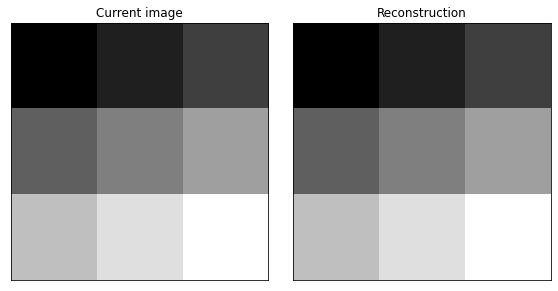

In [78]:
# time is the total sample duration in ms
time = 3

# dt is the step size within the sample duration in ms
dt = 1.0

# input data
train_image = torch.FloatTensor([[80,70,60],[50,40,30],[20,10,0]])

# print train data
print("Input Datum:")
print(train_image)
print()

# create encoder and encode input
encoder = RepeatEncoder(time=time, dt=dt)
train_image = torch.FloatTensor([[80,70,60],[50,40,30],[20,10,0]])
encoded_image = encoder(train_image)
print("Encoded Datum:")
print(encoded_image)

# plot image
e_img = encoded_image.view(int(time / dt), 1, 1, 3, 3)
inpt = e_img.view(int(time/dt), 9).sum(0).view(3, 3)
plot_input(train_image,inpt)

## 4c. Poisson Encoder

### Summary
Generates Poisson-distributed spike trains based on input intensity. Inputs must be non-negative, and give the firing rate in Hz. Inter-spike intervals (ISIs) for non-negative data incremented by one to avoid zero intervals while maintaining ISI distributions.

### Limitations
* Inputs must be non-negative
* Inputs must be floating point numbers (otherwise the rate will zero out)

### Rate Calculation

1. Compute firing rates in seconds as a function of data intensity
    * rate = (1 / input_intensity) * (1000 / dt)
    * higher intensity -> lower inter-spike interaval
    * dt = simulation time step
2. Create Poisson distribution and sample inter-spike intervals
    * `torch.distributions.Poisson()` used to generate samples
    * `time/dt` samples are taken for each input element based on the probability density function (pdf) of a Poisson distribution
        * Vales near the rate (lambda) more likely to occur
        * The higher the rate, the more varied the data will be
    * if any samples produced 0, set them to 1
3. Incrementally add all of the samples generated for each input element
    * this produces indexes of where to set the spike outputs for each element in the spikes array
    * if any samples are greater than `time/dt`, set them to 0 because they are outside of the sample duration
4. Create tensor of spikes
    * for each of the indexes produced, set the corresponding indexes in the spike tensor to 1
    * given an input tensor with dimsnions X x Y, the output tensor has dimensions (time/dt + 1) x X x Y
    * remove the first row of spikes because they are all set to 1
5. Summary
    * samples = time/dt
    * rate = (1/intensity)*(1000/dt)
    * intervals = torch.distributions.Poisson(rate=rate).sample(sample_shape=samples)
    * times = torch.cumsum(intervals,dim=0).long()
    * spikes\[times] = 1

### Poisson Distribution

![Poisson Probability Function](https://wikimedia.org/api/rest_v1/media/math/render/svg/c22cb4461e100a6db5f815de1f44b1747f160048)

![Poisson Probability Graph Function](https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Poisson_pmf.svg/325px-Poisson_pmf.svg.png)

where
* k is the number of occurrences
* λ is the rate (mean number of occurrences in the interval)

(Source [wikipedia.org](https://en.wikipedia.org/wiki/Poisson_distribution))

Input Datum:
tensor([[100.0000,  75.0000,  50.0000],
        [ 25.0000,  15.0000,  10.0000],
        [  5.0000,   2.5000,   0.0000]])

Rates for Each Element:
	Rate for 100.0: 10 Hz (Approx. 1 spike per  1 time steps.)
	Rate for 75.0: 13 Hz (Approx. 1 spike per  1 time steps.)
	Rate for 50.0: 20 Hz (Approx. 1 spike per  2 time steps.)
	Rate for 25.0: 40 Hz (Approx. 1 spike per  4 time steps.)
	Rate for 15.0: 67 Hz (Approx. 1 spike per  7 time steps.)
	Rate for 10.0: 100 Hz (Approx. 1 spike per  10 time steps.)
	Rate for 5.0: 200 Hz (Approx. 1 spike per  20 time steps.)
	Rate for 2.5: 400 Hz (Approx. 1 spike per  40 time steps.)
	Rate for 0.0: 0 Hz (Approx. 1 spike per  0 time steps.)

Encoded Datum:
tensor([[[1, 1, 1],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[1, 1, 1],
         [0, 0, 0],
         [0, 0, 0]],

        [[1, 1, 1],
         [1, 0, 0],
         [0, 0, 0]],

        [[1, 0, 1],
         [0, 0, 0],
   

(array([<AxesSubplot:title={'center':'Current image'}>,
        <AxesSubplot:title={'center':'Reconstruction'}>], dtype=object),
 (<matplotlib.image.AxesImage at 0x13d27a5d0>,
  <matplotlib.image.AxesImage at 0x13d381510>))

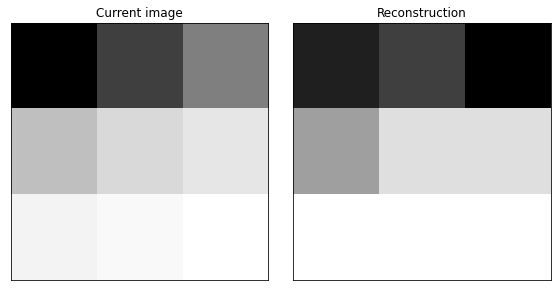

In [79]:
# time is the total sample duration in ms
time = 100

# dt is the step size within the sample duration in ms
dt = 10

# input data
train_image = torch.FloatTensor([[100,75,50],[25,15,10],[5,2.5,0]])

# print train data
print("Input Datum:")
print(train_image)
print()

# rates
print("Rates for Each Element:")
for element in train_image.flatten():
    rate = ((1/element.item())*(1000/dt)) if (element.item() != 0) else 0
    print("\tRate for "+str(element.item())+":",round(rate*dt),"Hz","(Approx. 1 spike per ",round(rate),"time steps.)")
print()

# create encoder and encode input
encoder = PoissonEncoder(time=time, dt=dt)
encoded_image = encoder(train_image)
print("Encoded Datum:")
print(encoded_image)

# plot image
e_img = encoded_image.view(int(time / dt), 1, 1, 3, 3)
inpt = e_img.view(int(time / dt), 9).sum(0).view(3, 3)
plot_input(train_image,inpt)

## 4d. Bernoulli Encoder
### Summary
Generates Bernoulli-distributed spike trains based on input intensity. Inputs must be non-negative. Spikes correspond to successful Bernoulli trials, with success probability equal to (normalized in \[0, 1]) input value. A maximum probability can be set using the `max_prob` argument

### Limitations
* Inputs must be non-negative
* Inputs must be floating point numbers (otherwise the rate will zero out)

### Bernoulli Trial Calculation
1. Inputs are normalized based on the max intensity
    * The highest intensity will have a probability of 1 and always spike
    * An intensity of 0 will have a probability of 0 and never spike
2. The spike tensor is generated using `torch.bernoulli()` to generate the random samples
    * Highest intensity will always produce 1, lower intensities will generate 1's based on their scale against the highest intensity

Input Datum:
tensor([[80., 70., 60.],
        [50., 40., 30.],
        [20., 10.,  0.]])

Probabilities of Spiking for Each Element per time step:
	Probability for 80.0 to spike per time step: 100%
	Probability for 70.0 to spike per time step: 88%
	Probability for 60.0 to spike per time step: 75%
	Probability for 50.0 to spike per time step: 62%
	Probability for 40.0 to spike per time step: 50%
	Probability for 30.0 to spike per time step: 38%
	Probability for 20.0 to spike per time step: 25%
	Probability for 10.0 to spike per time step: 12%
	Probability for 0.0 to spike per time step: 0%

Encoded Datum:
tensor([[[1, 1, 1],
         [1, 1, 1],
         [0, 0, 0]],

        [[1, 1, 1],
         [1, 1, 1],
         [0, 0, 0]],

        [[1, 1, 1],
         [1, 0, 0],
         [1, 0, 0]],

        [[1, 1, 0],
         [1, 1, 0],
         [0, 0, 0]],

        [[1, 1, 0],
         [1, 1, 0],
         [0, 0, 0]],

        [[1, 0, 1],
         [1, 0, 1],
         [0, 0, 0]],

        [[1, 1, 

(array([<AxesSubplot:title={'center':'Current image'}>,
        <AxesSubplot:title={'center':'Reconstruction'}>], dtype=object),
 (<matplotlib.image.AxesImage at 0x13d32a550>,
  <matplotlib.image.AxesImage at 0x13d402d10>))

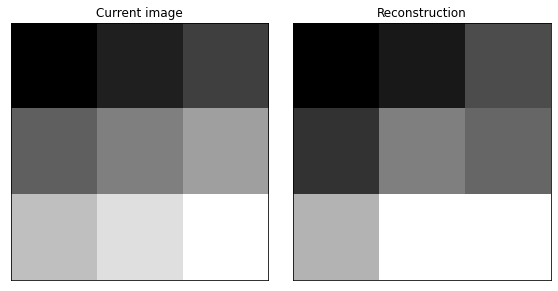

In [80]:
# time is the total sample duration in ms
time = 10

# dt is the step size within the sample duration in ms
dt = 1.0

# input data
train_image = torch.FloatTensor([[80,70,60],[50,40,30],[20,10,0]])

# print train data
print("Input Datum:")
print(train_image)
print()

# probabilities
print("Probabilities of Spiking for Each Element per time step:")
for element in train_image.flatten():
    prob = (element.item() / train_image.max()) * 100
    print("\tProbability for "+str(element.item())+" to spike per time step:",str(round(prob.item()))+"%")
print()

# create encoder and encode input
encoder = BernoulliEncoder(time=time, dt=dt)
encoded_image = encoder(train_image)
print("Encoded Datum:")
print(encoded_image)

# plot image
e_img = encoded_image.view(int(time / dt), 1, 1, 3, 3)
inpt = e_img.view(int(time / dt), 9).sum(0).view(3, 3)
plot_input(train_image,inpt)

## 4e. Rank Order Encoder
### Summary
Encodes data via a rank order coding-like representation. One spike per neuron, temporally ordered by decreasing intensity. Inputs must be non-negative.

### Rank Calculations
1. Normalize data based on the max value
2. Invert the data to get the times
    * Higher Values correspond to Lower Times
3. Divide the data by the max time
    * Time values are rounded up to the next value and converted to int to get the ranks
4. For each element, if the rank is within `time/dt` time steps, assign a spike to the time step corresponding to the rank

### Limitations
* Elements need to be widely varied to avoid rank overlap
* The same rank can repeat multiple times

Input Datum:
tensor([[100.,  90.,  80.],
        [ 70.,  60.,  50.],
        [ 40.,  30.,  20.]])

Ranks of Spiking for Each Element per time step:
tensor([ 2.0000,  2.2222,  2.5000,  2.8571,  3.3333,  4.0000,  5.0000,  6.6667,
        10.0000])
	Rank for 100.0 is: 2
	Rank for 90.0 is: 3
	Rank for 80.0 is: 3
	Rank for 70.0 is: 3
	Rank for 60.0 is: 4
	Rank for 50.0 is: 4
	Rank for 40.0 is: 5
	Rank for 30.0 is: 7
	Rank for 20.0 is: 10

Encoded Datum:
tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[1, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 1, 1],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 1, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [1, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0

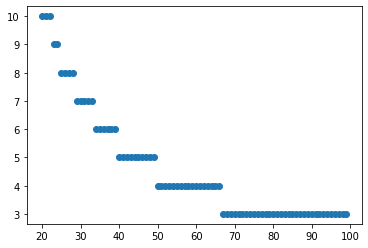

In [84]:
# time is the total sample duration in ms
time = 10

# dt is the step size within the sample duration in ms
dt = 1.0

# input data
# train_image = torch.FloatTensor([[80,70,60],[50,40,30],[20,10,0]])
train_image = torch.FloatTensor([[100,90,80],[70,60,50],[40,30,20]])
# train_image = torch.FloatTensor([[10,5,3.333],[2.5,2,1.63],[1.5,1.2,0.9]])
# train_image = torch.FloatTensor([100,75,50,25,0])

# print train data
print("Input Datum:")
print(train_image)
print()

# ranks
print("Ranks of Spiking for Each Element per time step:")
datum = train_image
datum = (datum / datum.max()).flatten()
times = torch.zeros(datum.numel())
times[datum != 0] = 1 / datum[datum != 0]
times *= time / times.max()
print(times)
times = torch.ceil(times).long()
for idx in range(len(train_image.flatten().tolist())):
    elements = train_image.flatten().tolist()
    print("\tRank for "+str(round(elements[idx],2))+" is:",str(times[idx].item()))
print()

# create encoder and encode input
encoder = RankOrderEncoder(time=time, dt=dt)

encoded_image = encoder(train_image.clone())
print("Encoded Datum:")
print(encoded_image)
print()

# plot image
# e_img = encoded_image.view(int(time / dt), 1, 1, 3, 3)
# inpt = e_img.view(int(time / dt), 9).sum(0).view(3, 3)
# plot_input(train_image,inpt)
# plt.show()

print("Rank Plot:")
plt.figure()
x = torch.arange(max(train_image.min(),1),train_image.max(),1).float()
x_times = (1/(x / x.max()))
x_times *= (time/dt) / x_times.max()
ranks = torch.ceil(x_times).long()
plt.scatter(x,ranks)
plt.show()

## Future Modifications
* Change the rank order coding add an option for each element having their own rank